In [1]:
import mib as mb1
import mib_v2_3_2 as mb
import matplotlib.pyplot as plt
import time
import tracemalloc
import tpproc as tp
from collections import Counter  #regresa un diccionario con conteos
import glob
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import OrderedDict #diccionarios ordenados
import numpy as np
from itertools import product
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/roberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Test 1

## Planteamiento

Comprobar del rendimiento del motor de inferencia con problema pequeño y con tres eventos con distribuciones uniformes, donde su cardinalidad de los tres va de uno a cien.

### Variables

- $A = \{0, 2, ..., n-1\}$

- $B = \{0, 2, ..., n-1\}$

- $C = \{0, 2, ..., n-1\}$

### Modelo de descomposición

$P(ABC) = P(A)P(B|A)P(C|AB)$.

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./Imagenes/P(ABC).jpg" width=200/>

### Formas 

$P(A)$, $P(B|A)$ y $P(C|AB)$ serán distribuciones uniformes.

## Test

### MIB1.0

In [ ]:
n = 25
timesM1 = []
memoryM1 = []

timesC1 = []
memoryC1 = []

for i in range(21,22):
    Events = [x for x in range(i+1)]
    # Varaibles
    A = mb1.Var('A',Events)
    B = mb1.Var('B',Events)
    C = mb1.Var('C',Events)

    dA = {}
    dB_A = {}
    dC_AB = []
    value = 1 / (i+1)
    for e in Events:
        dA[e] = value
        dB_A[e] = {}
        for e1 in Events:
            dB_A[e][e1] = value
            tC_AB = []
            for e2 in Events:
                tC_AB.append(value)
            dC_AB.append(tuple(tC_AB))
    
    PA=mb1.Distrib(name='P(A)',variable=[A],tabla=dA)
    PB_A=mb1.DistribCond(name='P(B|A)',var=B,indep=[A],tabla=dB_A)
    PC_AB=mb1.DistribCond('P(C|AB)',C,[A,B],dC_AB)
    
    PABC=mb1.JointDistrib(name='P(ABC)',variables=[A,B,C],descomp=[PA,PB_A,PC_AB])
    Q_ABC=mb1.Question(joint=PABC)

    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.query(searched=[B])
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM1.append(tiempo_ejecucion)
    memoryM1.append(memoria_pico)
    
    #Inferencia de P(A|BC)
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.query(searched=[A], known=[B,C])
    fin = time.time() 
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC1.append(tiempo_ejecucion)
    memoryC1.append(memoria_pico)

### MIB2.0

Complejidad $O(3) = 25^3$

In [13]:
n = 25
timesM = []
memoryM = []

timesC = []
memoryC = []
test_n = 20
for i in range(n):
    Events = set([x for x in range(i+1)])
    
    # Generación de distribuciones de probabilidad (Distribuciones uniformes).
    dA = {}
    dB_A = {}
    dC_AB = {}
    value = 1 / (i+1)
    for x in range(i+1):
        dA[(x,)] = value
        dB_A[(x,)] = {}
        for y in range(i+1):
            dB_A[(x,)][(y,)] = value
            dC_AB[(x,y)] = {}
            for z in range(i+1):
                dC_AB[(x,y)][(z,)] = value
    
    # Variables para el motor de inferencia.
    A = mb.Var('A', Events)
    PA = mb.Distrib(dA, (A,))
    B = mb.Var('B', Events)
    PB_A = mb.Distrib(dB_A, (B,), (A,))
    C = mb.Var('C', Events)
    PC_AB = mb.Distrib(dC_AB, (C,), (A,B))
    
    # Probabilidad conjunta (Espesificación)
    PABC = mb.Specification(set([A,B,C]), (PA, PB_A, PC_AB))

    Q_ABC = mb.Question(PABC)
    
    timesM_i = 0
    memoryM_i = 0
    timesC_i = 0
    memoryC_i = 0
    for j in range(test_n):
        # Inferencia de una distibución marginal
        tracemalloc.start()
        
        inicio = time.time()
        PB = Q_ABC.DistributionQuery(set([B]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesM_i += tiempo_ejecucion
        memoryM_i += memoria_actual
        
        # Inferencia de una distibución condicional 
        tracemalloc.start()
        
        inicio = time.time()
        PA_BC = Q_ABC.DistributionQuery(set([A]), set([B,C]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_i += tiempo_ejecucion
        memoryC_i += memoria_actual
    
    timesM.append(timesM_i / test_n)
    memoryM.append(memoryM_i / test_n)
    timesC.append(timesC_i/ test_n)
    memoryC.append(memoryC_i / test_n)

## Datos obtenidos

In [3]:
with open("versiones//datosMIB1.json", "r") as archivo_json:
    datos = json.load(archivo_json)
timesM1 = datos["timesM1"]
timesC1 = datos["timesC1"]
memoryM1 = datos["memoryM1"]
memoryC1 = datos["memoryC1"]

In [179]:
len(timesM1)

25

### Tiempos

#### Tiempos de inferencia para $P(B)$

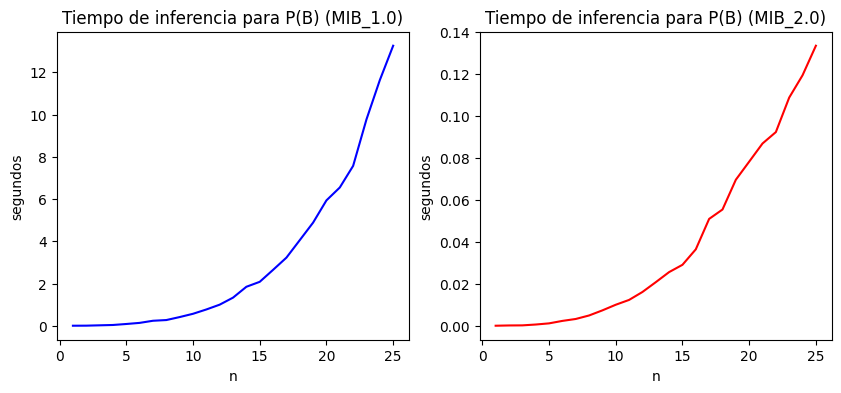

In [5]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
# fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, timesM1, color='b',label = 'MIB_1.0')
ax[0].set_title("Tiempo de inferencia para P(B) (MIB_1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")

# MIB_2.0
ax[1].plot(xn, timesM, color='r',label = 'MIB_2.0')
ax[1].set_title("Tiempo de inferencia para P(B) (MIB_2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.show()

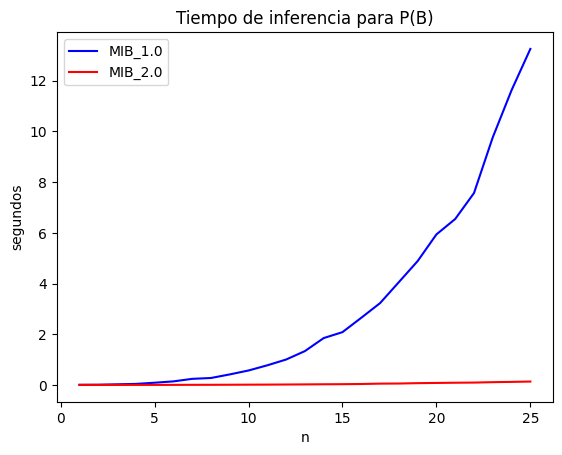

In [6]:
fig, ax = plt.subplots()
xn = [i+1 for i in range(n)]
# MIB_1.0
ax.plot(xn, timesM1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesM, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Tiempos de inferencia para $P(C|AB)$

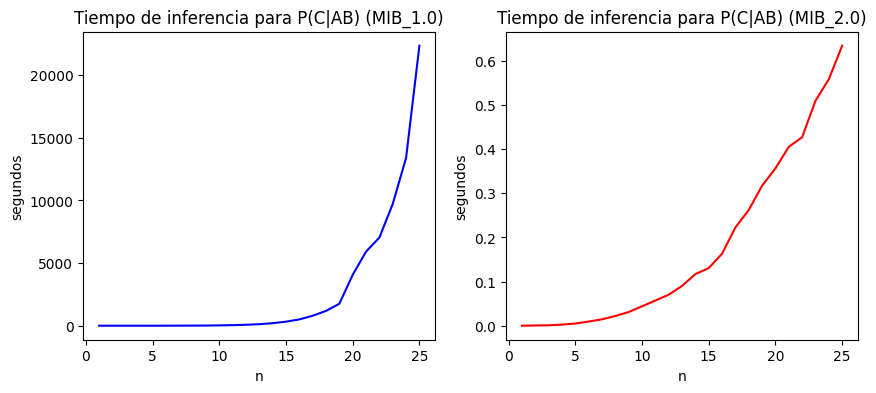

In [7]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
# MIB_1.0
ax[0].plot(xn, timesC1, color='b',label = 'MIB_1.0')
ax[0].set_title("Tiempo de inferencia para P(C|AB) (MIB_1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")

# MIB_2.0
ax[1].plot(xn, timesC, color='r',label = 'MIB_2.0')
ax[1].set_title("Tiempo de inferencia para P(C|AB) (MIB_2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.show()

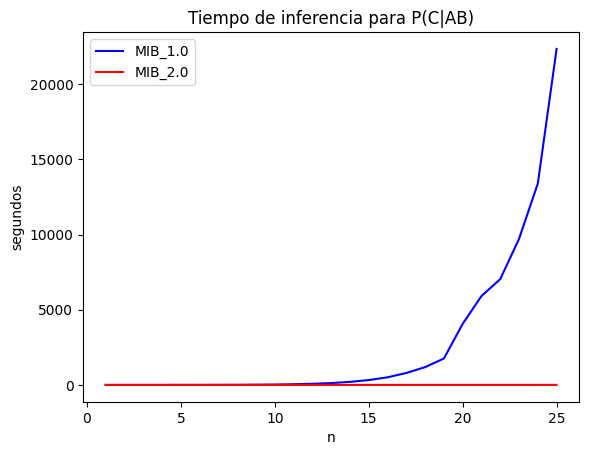

In [8]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesC1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesC, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(C|AB)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

### Memoria

#### Memoria para la inferencia de P(B)

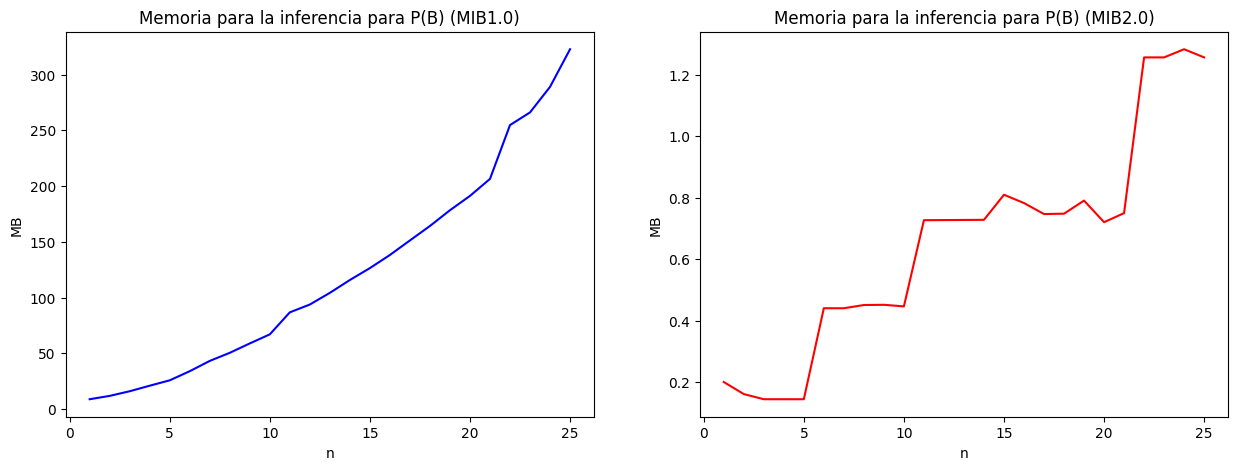

In [15]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, [m/1000 for m in memoryM1], color='b',label = 'MIB_1.0')
ax[0].set_title("Memoria para la inferencia para P(B) (MIB1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("MB")

# MIB_2.0
ax[1].plot(xn, [m/1000 for m in memoryM], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia para P(B) (MIB2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")

# Mostrar las gráficas
plt.show()

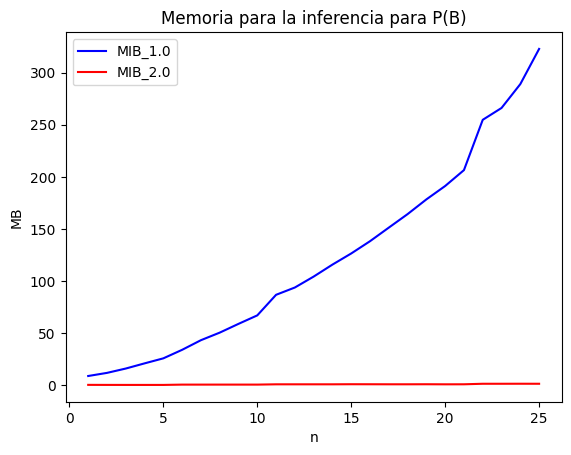

In [17]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, [m/1000 for m in memoryM1], color='b',label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, [m/1000 for m in memoryM], color='r',label = 'MIB_2.0')
ax.set_title("Memoria para la inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Memoria para la inferencia de P(C|AB)

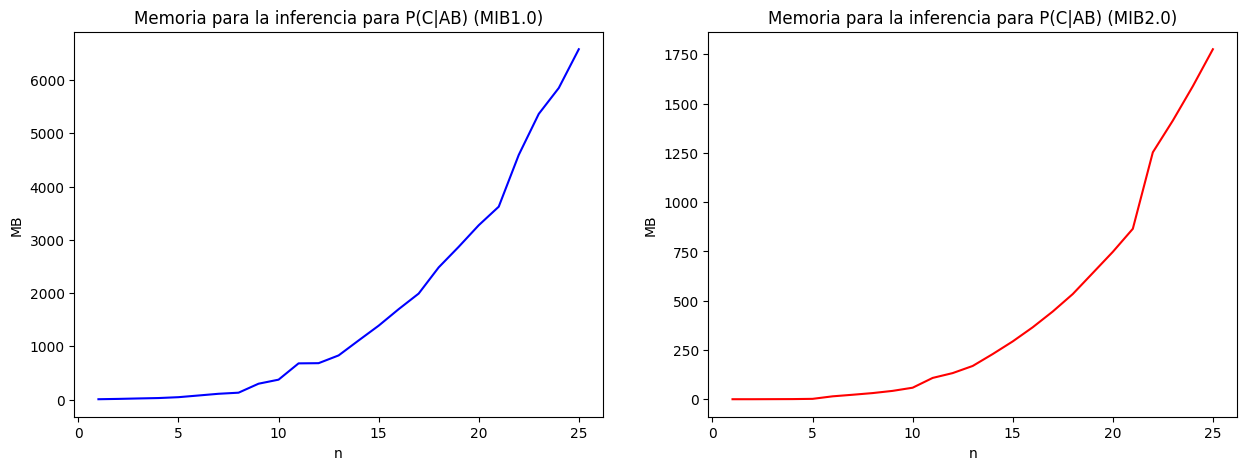

In [18]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, [m/1000 for m in memoryC1], color='b',label = 'MIB_1.0')
ax[0].set_title("Memoria para la inferencia para P(C|AB) (MIB1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("MB")

# MIB_2.0
ax[1].plot(xn, [m/1000 for m in memoryC], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia para P(C|AB) (MIB2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")

# Mostrar las gráficas
plt.show()

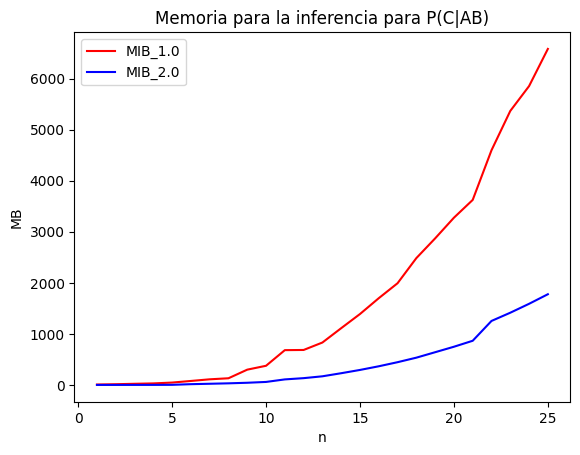

In [19]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, [m/1000 for m in memoryC1], color='r',label = 'MIB_1.0')
# MIB_2.0
ax.plot(xn, [m/1000 for m in memoryC], color='b',label = 'MIB_2.0')

ax.set_title("Memoria para la inferencia para P(C|AB)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

# Test 2

## Planteamiento

Comprobar del rendimiento del motor de inferencia n variables binarias.

### Variables

$X = \{X_1, X_2,\dots,X_n\}$, donde $\forall X_i \in X, X_i = \{0,1\}$.

### Modelo de descomposición

$P(X) = P(X_1)P(X_2|X_1)P(X_3|X_1,X_2) \cdots P(X_n|X_1,\dots,X_{n-1})$.

## Test

### MIB1.0

### MIB2.0

Complejidad: $O(n) = 2^n$

$t_m(n) = 2^n * n$

#### Conjunta

In [20]:
from itertools import product
n = 20
timesM = []
memoryM = []
timesM_A = []
memoryM_A = []
test_n = 5
for i in range(n):
    print(i+1)
    values = set([0,1])
    
    vars = tuple([mb.Var("X"+str(j+1), values) for j in range(i+3)])
    

    for j,var in enumerate(vars):
        if j == 0:
            tX1 = {(0,):0.5, (1,):0.5}
            descomp = [mb.Distrib(tX1, (var,))]
        else:
            for r in range(j):
                tXn = {}
                values_n = [list(xn.values) for xn in vars[:r+1]]
                for key in product(*values_n):
                    tXn[key] = {(0,):0.5, (1,):0.5}
            descomp.append(mb.Distrib(tXn, (var,), tuple(vars[:j]) ))
    
    QX1Xn = mb.Question(mb.Specification(set(vars), tuple(descomp)))
    
    timesM_i = 0
    memoryM_i = 0
    timesM_Ai = 0
    memoryM_Ai = 0
    
    for m in range(test_n):
        print(f"\t{m+1}")
        # Inferencia de una distibución marginal
        """ tracemalloc.start()
        
        inicio = time.time()
        PXn = QX1Xn.DistributionQuery(set([vars[-1]]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        tiempo_ejecucion = fin - inicio
        
        timesM_i += tiempo_ejecucion
        memoryM_i += memoria_actual """
        
        # Aproximación de una distibución marginal
        tracemalloc.start()
        
        inicio = time.time()
        PXn = QX1Xn.DistributionQuery(set([vars[-1]]), aproximation=True, process_n=16)
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        tiempo_ejecucion = fin - inicio
        
        timesM_Ai += tiempo_ejecucion
        memoryM_Ai += memoria_actual
    
    # timesM.append(timesM_i / test_n)
    # memoryM.append(memoryM_i / test_n)
    timesM_A.append(timesM_Ai / test_n)
    memoryM_A.append(memoryM_Ai / test_n)

1
	1
	2
	3
	4
	5
2
	1
	2
	3
	4
	5
3
	1
	2
	3
	4
	5
4
	1
	2
	3
	4
	5
5
	1
	2
	3
	4
	5
6
	1
	2
	3
	4
	5
7
	1
	2
	3
	4
	5
8
	1
	2
	3
	4
	5
9
	1
	2
	3
	4
	5
10
	1
	2
	3
	4
	5
11
	1
	2
	3
	4
	5
12
	1


KeyboardInterrupt: 

#### Condicional

In [65]:
n = 5
timesC = []
memoryC = []
timesC_A = []
memoryC_A = []

test_n = 10
N = 40000
for i in range(n):
    print(i+1)
    values = set([0,1])
    
    vars = tuple([mb.Var("X"+str(j), values) for j in range(i+2)])

    for j,var in enumerate(vars):
        if j == 0:
            dX0 = {(0,):0.5, (1,):0.5}
            descomp = [mb.Distrib(dX0, (var,))]
        elif j == 1:
            dX1 = {
                (0,) : {(0,):0.5, (1,):0.5},
                (1,) : {(0,):0.5, (1,):0.5}
            }
            descomp.append(mb.Distrib(dX1, (var,), (vars[0],),))
        else:
            dXn = {}
            values_n = [list(xn.values) for xn in vars[:j-1]]
            for key in product(*values_n):
                dXn[key] = {(0,):0.5, (1,):0.5}
            descomp.append(mb.Distrib(dXn, (var,), tuple(vars[:j-1])))
    
    QX1Xn = mb.Question(mb.Specification(set(vars), tuple(descomp)))
    
    timesC_i = 0
    memoryC_i = 0
    timesC_Ai = 0
    memoryC_Ai = 0
    for m in range(test_n):
        print(f"\t{m+1}")
        # Inferencia de una distibución condicional 
        """ tracemalloc.start()
        
        inicio = time.time()
        PX1_X2Xn = QX1Xn.DistributionQuery(set([vars[0]]), set([vars[1],vars[-1]]))
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_i += tiempo_ejecucion
        memoryC_i += memoria_actual """
        
        # Aproximación de una distibución condicional 
        tracemalloc.start()
        
        inicio = time.time()
        PX1_Xn = QX1Xn.DistributionQuery(set([vars[0]]), set([vars[-1]]), aproximation=True, N=N)
        # PX1_X2Xn = QX1Xn.DistributionQuery(set([vars[0]]), set([vars[1],vars[-1]]), aproximation=True)
        fin = time.time()
        
        memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        tiempo_ejecucion = fin - inicio
        
        timesC_Ai += tiempo_ejecucion
        memoryC_Ai += memoria_actual
    
    # timesC.append(timesC_i/ test_n)
    # memoryC.append(memoryC_i / test_n)
    timesC_A.append(timesC_Ai / test_n)
    memoryC_A.append(memoryC_Ai / test_n)
    

1
	1


KeyboardInterrupt: 

In [140]:
mp = 0
for i in range(1,100):
    mp += (timesC_A[i] - timesC_A[i-1])
mp / (100 - 1)

2.0694586859809028

In [50]:
def t1000(x:int) -> float:
    return 0.11763986216651068 * x

In [51]:
def t10000(x:int) -> float:
    return (0.8919548723432753 * x)  + 0.3183024686721987

In [52]:
def t17500(x:int, b:float = 0.0005555581286976537) -> float:
    return (2.0694586859809028 * x) + b

In [53]:
def t25000(x:int, b:float = -0.041077795471430104):
    return (3.24696249961853 * x) + b

In [54]:
def t50000(x:int) -> float:
    return (6.563827234506607 * x) - 0.31809051576543457

In [139]:
timesC_A = []
for i in range(100):
    d = t25000(i+2) - t10000(i+2)
    t = t10000(i+2) + (d/2)
    timesC_A.append(t)

In [151]:
e = 0
for i in range(100):
    e += (timesC_A[i] - t17500(i+2)) / timesC_A[i]
e / (n-1)

0.0005555671618301966

In [147]:
e = 0
b = 0.0005555581286976537
for j in range(10000):
    for i in range(100):
        e += (timesC_A[i] - (t25000(i+2, b))) / timesC_A[i]
        # e += (timesC_A[i] - t10000(i+2)) / timesC_A[i]
    e = e / (n-1)
    b = (b+e) / 2
b

-0.11292298264205164

In [256]:
i = 8
timesC_A[i], t10000(i+2)

(9.285991668701172, 9.237851192104952)

In [165]:
t1000(500)

0.9803321847209223

In [265]:
(t10000(500) / 60) * 10

74.3826231067183

In [5]:
import json

""" # Diccionario que deseas guardar
mi_diccionario = {
    "timesM": timesM,
    "timesC": timesC,
    "memoryM": memoryM,
    "memoryC": memoryC
}

# Guardar el diccionario en un archivo JSON
with open("datos_MIB2.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4) """
    
# mi_diccionario.clear()
mi_diccionario = {
    "timesM": timesM_A,
    "timesC": timesC_A,
    "memoryM": memoryM_A,
    "memoryC": memoryC_A
}

# Guardar el diccionario en un archivo JSON
with open("datosA_MIB2.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4)

In [ ]:
with open("datos_MIB2.json", "r") as archivo_json:
    datos = json.load(archivo_json)
timesM = datos["timesM"]
timesC = datos["timesC"]
memoryM = datos["memoryM"]
memoryC = datos["memoryC"]

## Datos

In [2]:
def grafica_(list1, list2, title1, title2, xn, x_label, y_label):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12,6)
    ax[0].plot(xn, list1, color='b',label = 'Exacta')
    ax[0].set_title(title1)
    ax[0].set_xlabel(x_label)
    ax[0].set_ylabel(y_label)


    ax[1].plot(xn, list2, color='r',label = 'Aproximación')
    ax[1].set_title(title2)
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel(y_label)
    
    plt.show()
    

In [3]:
def grafica_n(ys:list, x:list, labels:list,  title:str, x_label:str, y_label:str) -> None:
    fig, ax = plt.subplots()
    
    for i,y in enumerate(ys):
        ax.plot(x[i], y, label = labels[i])
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc = 'upper left')
    plt.grid()
    plt.show()

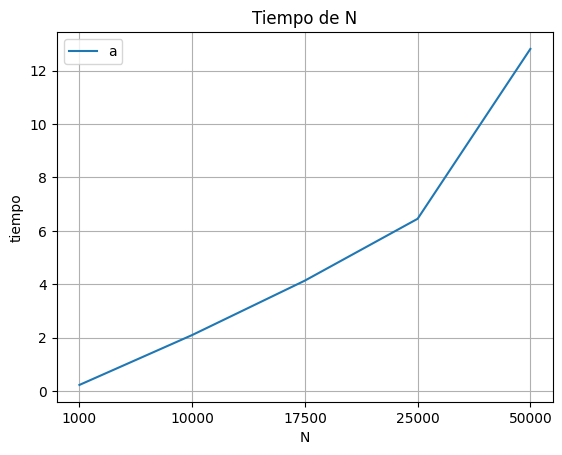

In [64]:
Ns = [t1000(2),t10000(2),t17500(2),t25000(2),t50000(2)]
xn = ['1000', '10000','17500','25000','50000']

grafica_n([Ns], [xn], ["a"], 'Tiempo de N', 'N', 'tiempo')


### Marginal

#### Tiempos

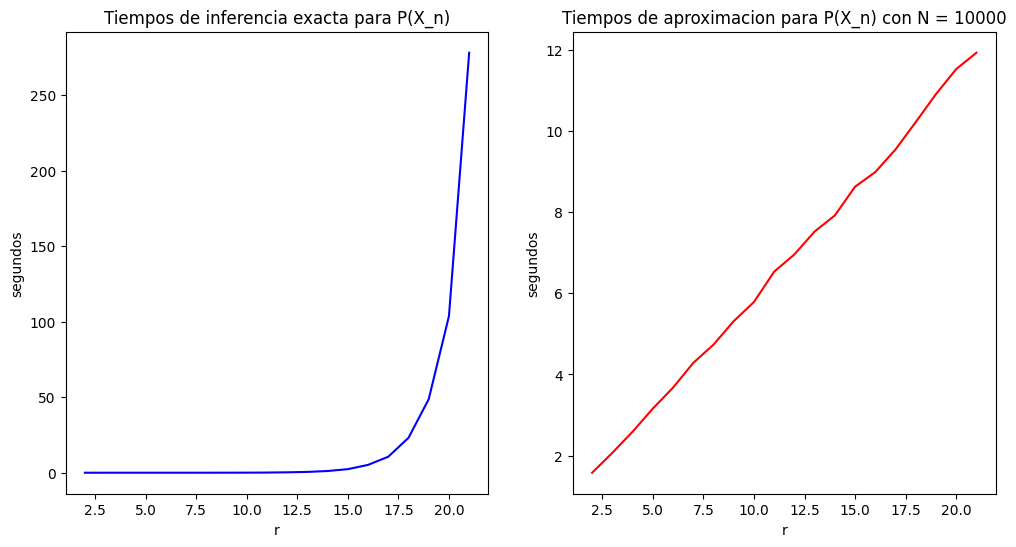

In [30]:
xn = [i+2 for i in range(n)]
title1 = "Tiempos de inferencia exacta para P(X_n)"
title2 = "Tiempos de aproximacion para P(X_n) con N = 10000"
grafica_(timesM, timesM_A, title1, title2, xn, 'r', 'segundos')

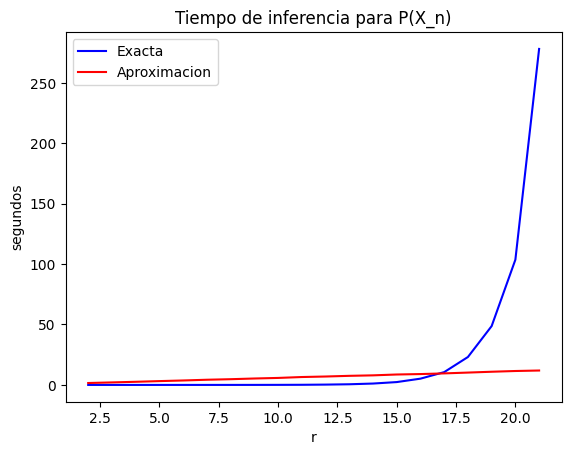

In [31]:
grafica_n([timesM, timesM_A], ['Exacta', 'Aproximacion'], "Tiempo de inferencia para P(X_n)", xn, 'n', 'segundos')

### Condicional 

#### Tiempos

In [ ]:
n = 500
t_mil = [t1000(i+2) / 60 for i in range(n)]
t_10mil = [t10000(i+2) / 60 for i in range(n)]
t_25mil = [t25000(i+2) / 60 for i in range(n)]
t_50mil = [t50000(i+2) / 60 for i in range(n)]
x = [i+2 for i in range(n)]

labels = ['N=1000','N=10000','N=25000','N=50000']
ys = [t_mil, t_10mil, t_25mil,t_50mil]

grafica_n(ys, x, labels,'Tiempo de Aproximación para P(X_1|X_2,X_n)','n', 'mins')

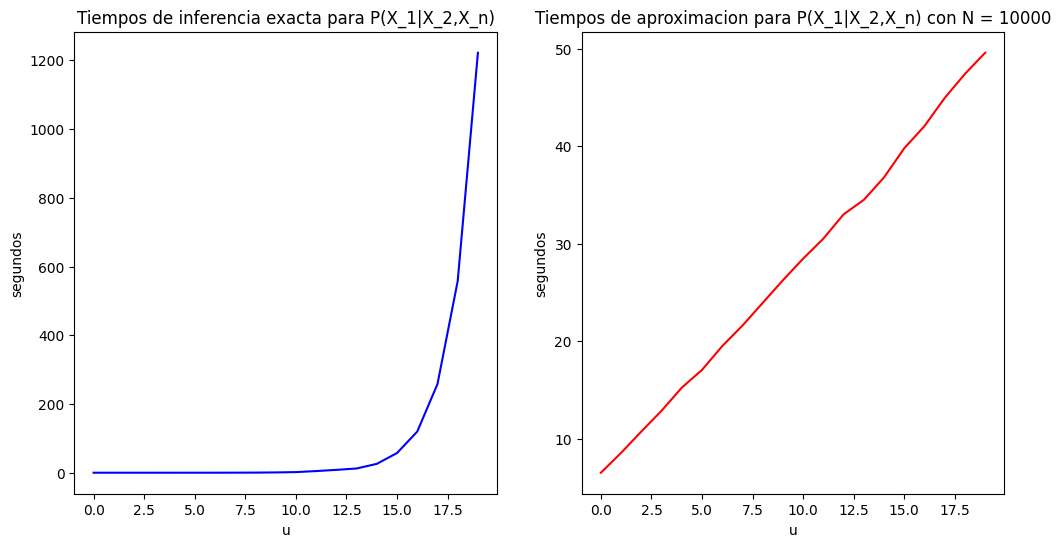

In [28]:
xn = [i for i in range(n)]
title1 = "Tiempos de inferencia exacta para P(X_1|X_2,X_n)"
title2 = "Tiempos de aproximacion para P(X_1|X_2,X_n) con N = 10000"
grafica_(timesC, timesC_A, title1, title2, xn, 'u', 'segundos')

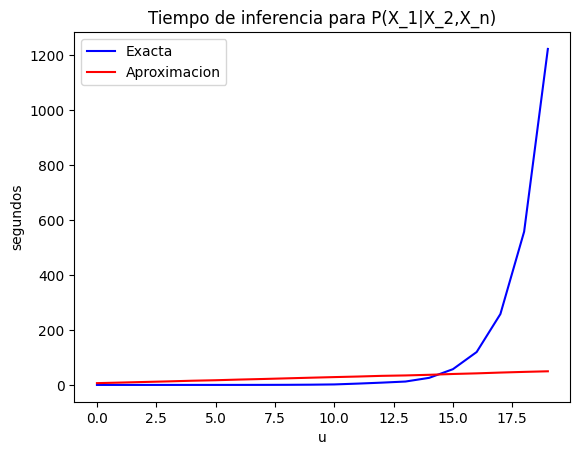

In [29]:
grafica(timesC, timesC_A, 'Exacta', 'Aproximacion', "Tiempo de inferencia para P(X_1|X_2,X_n)", xn, 'u', 'segundos')

# Test 3

Problema de autoria de textos 

## Plantemiento

### Especificaión 

#### Variables

- $A$ : Variable para los autores
- $T$ : Variable para los tipos de textos
- $W_I$ : Variable para las palabras

##### Variable $A$

$|A| = 10 $

##### Variable $T$

$ T = \{'minicuento', 'fábula', 'cuento'\} $

##### Variable $W_i$

$ W_i = \{0,1\}$, donde cada $W_i$ representa una variable para cada palabra.

Si $W_i$ es 0, entonces la palabra no esta. Si $W_i$ es 1 entonces la palabra esta.

$W = \{W_1,W_2,\dots,W_n\}$

#### Modelo de descomposición

$P(A)P(T|A)\displaystyle \prod_{i=0}^{n} P(W_i|AT)$

## Metodología

### Obtención de datos

#### Obtención de datos para el entrenamiento

In [21]:
archivos = glob.glob('./Train/*/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_train = tp.lee_cuentos(archivos)
df_train.head()

leyendo...
tamaño del contenido de archivos cargados:             1 KB


,titulo,tipo,autor,texto
0,la luz es como el agua,cuento,gabriel garcía márquez,navidad niños volvieron pedir bote remos acuer...
1,un niño como yo,minicuento,gabriel garcía márquez,niño cinco años perdido madre muchedumbre feri...
2,la fotogenia del fantasma,minicuento,gabriel garcía márquez,fantasmas acomodándose nuevas circunstancias e...
3,el drama del desencantado,minicuento,gabriel garcía márquez,drama desencantado arrojó calle décimo piso me...
4,el almohadón de plumas,cuento,horacio quiroga,luna miel largo escalofrío rubia angelical tím...


#### Obtención de datos para el test

In [22]:
archivos = glob.glob('./Test/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_test = tp.lee_cuentos(archivos,test=True)
df_test.head()

leyendo...
tamaño del contenido de archivos cargados:             0 KB


,titulo,texto
0,la melancolía del viajero,veces vuelven largo viaje conservan toda vida ...
1,el águila de ala cortada y la zorra,cierto día hombre capturó águila cortó alas so...
2,los dos cazadores,cierto día mayo alegría tristeza encontraron o...
3,maravillas de la voluntad,tres punto don pedro llegaba mesa saludaba cad...
4,la escopeta,noche cerrada estiré brazo encender lámpara me...


#### Reducción de vocabulario

In [23]:
def vocab(max:int = None, min = 5) -> set:
    s = df_train.texto.str.cat(sep=' ').split()
    conteos = Counter(s)
    nuevo_vocabulario = set(conteos)
    print(len(nuevo_vocabulario))
    if max:
        nuevo_vocabulario =  set([key for key, _ in conteos.most_common(max)])
    else:
        nuevo_vocabulario = set([palabra for palabra in s if conteos[palabra] >= min])
    print(len(nuevo_vocabulario))
    return nuevo_vocabulario

In [24]:
def vocab_aut(max:int=5) -> set:
    autores = set(df_train.autor)
    nvocab_a = {}
    nuevo_vocabulario = set()
    for a in autores:
        s = df_train[df_train['autor'] == a].texto.str.cat(sep=' ').split()
        conteos = Counter(s)
        nuevo_vocabulario_a = set(conteos)
        len_old_vocab = len(nuevo_vocabulario_a)
        nuevo_vocabulario_a =  set([key for key, _ in conteos.most_common(max)])
        nvocab_a[a] = [v for v in conteos.most_common(max)]
        print(f"{a}: old: {len_old_vocab}, new:{len(nuevo_vocabulario_a)}")
        nuevo_vocabulario = nuevo_vocabulario.union(nuevo_vocabulario_a)
    print(len(nuevo_vocabulario))
    return nuevo_vocabulario, nvocab_a

In [25]:
# nuevo_vocabulario = vocab(min=3)
nuevo_vocabulario, nvocab_a = vocab_aut(max=15)

juan carlos onetti: old: 385, new:15
gibrán jalil gibrán: old: 330, new:15
horacio quiroga: old: 733, new:15
esopo: old: 166, new:15
alfonso reyes: old: 211, new:15
jean de la fontaine: old: 377, new:15
josé saramago: old: 414, new:15
carlos fuentes: old: 1329, new:15
juan rulfo: old: 791, new:15
gabriel garcía márquez: old: 518, new:15
119


#### Data Frames de trabajo

In [26]:
df_train_T = df_train.copy()
df_train_T['nuevo_texto'] = df_train_T.texto.str.split().\
    apply(lambda texto: [w for w in texto if w in nuevo_vocabulario]).\
    apply(lambda x : ' '.join(x))
df_train_T['Conteos']=df_train_T.nuevo_texto.str.split().apply(Counter)


df_train_T.head()

,titulo,tipo,autor,texto,nuevo_texto,Conteos
0,la luz es como el agua,cuento,gabriel garcía márquez,navidad niños volvieron pedir bote remos acuer...,niños bote remos dijo papá totó años padres aq...,"{'niños': 7, 'bote': 9, 'remos': 4, 'dijo': 9,..."
1,un niño como yo,minicuento,gabriel garcía márquez,niño cinco años perdido madre muchedumbre feri...,niño años niño,"{'niño': 2, 'años': 1}"
2,la fotogenia del fantasma,minicuento,gabriel garcía márquez,fantasmas acomodándose nuevas circunstancias e...,fantasma tan ser fantasma ser fantasma años lu...,"{'fantasma': 5, 'tan': 1, 'ser': 2, 'años': 1,..."
3,el drama del desencantado,minicuento,gabriel garcía márquez,drama desencantado arrojó calle décimo piso me...,viendo aquella vida siempre puerta ser,"{'viendo': 1, 'aquella': 1, 'vida': 1, 'siempr..."
4,el almohadón de plumas,cuento,horacio quiroga,luna miel largo escalofrío rubia angelical tím...,largo noche jordán siempre casa aquella casa l...,"{'largo': 6, 'noche': 5, 'jordán': 16, 'siempr..."


In [27]:
df_test_T = df_test.copy()
df_test_T['nuevo_texto']=df_test_T.texto.str.split().\
    apply(lambda texto: [w for w in texto if w in nuevo_vocabulario]).\
    apply(lambda x : ' '.join(x))
df_test_T['nuevo_total']=df_test_T.nuevo_texto.str.split().apply(len)
df_test_T['Conteos']=df_test_T.nuevo_texto.str.split().apply(Counter)


df_test_T.head()

,titulo,texto,nuevo_texto,nuevo_total,Conteos
0,la melancolía del viajero,veces vuelven largo viaje conservan toda vida ...,largo vida solo vida ojos después dice tierra ...,19,"{'largo': 1, 'vida': 2, 'solo': 1, 'ojos': 1, ..."
1,el águila de ala cortada y la zorra,cierto día hombre capturó águila cortó alas so...,día hombre águila alas águila pasó hombre águi...,14,"{'día': 1, 'hombre': 2, 'águila': 3, 'alas': 3..."
2,los dos cazadores,cierto día mayo alegría tristeza encontraron o...,día tierra vida largo rato dos hacia dijo dos ...,25,"{'día': 2, 'tierra': 1, 'vida': 1, 'largo': 1,..."
3,maravillas de la voluntad,tres punto don pedro llegaba mesa saludaba cad...,cada ojos día casa dos cuarto después cada cad...,24,"{'cada': 3, 'ojos': 4, 'día': 2, 'casa': 1, 'd..."
4,la escopeta,noche cerrada estiré brazo encender lámpara me...,noche sangre luz tan cada puerta dos luz luego...,14,"{'noche': 1, 'sangre': 1, 'luz': 2, 'tan': 1, ..."


#### Vocabulario

In [28]:
voc_dict = OrderedDict(zip(nuevo_vocabulario,range(len(nuevo_vocabulario))))
v = list(voc_dict.keys())

### Creación de especificación

#### Variables

In [29]:
# Autor
autores = set(df_train_T.autor)
A = mb.Var('A',autores)
# Tipo 
tipos = set(df_train_T.tipo)
T = mb.Var('T',tipos)
# W_i
W = {}
for w in voc_dict:    # vocabulario reducido
    W[w] = mb.Var(w,set([0,1]))

#### Identificación de parámetros (estadísticas)

#### Método

1. Descomposición exacta: $P(A)P(T|A)P(W|AT)$
2. Calcular las estadísticas por cada distribución de la descomposición
3. Para la variable Autor $P(A)$:
    - 3.1 Contar el número total de ocurrencias de autores en Train: $n_a$.
    - 3.2 Contar el número de ocurrencias de cada autor en Train: $n_A = \sum_{a \in A} n_a$.
    - 3.3 Dividir este número entre el número total de ocurrencias de autores en Train: $\displaystyle \frac{n_a}{n_A}$.
4. Para la variable Tipo $P(T|A)$:
    - 4.1 Obtener el conjunto de autores (valores únicos) $a$; entradas a la Tabla.
    - 4.2 Obtener el conjunto de tipos (valores únicos) $t$; estas son las salidas de la Tabla.
    - 4.3 Calcular el producto cartesiano de las combinaciones posibles (a,t).
    - 4.4 Contar el número de ocurrencias totales de cada $t$ por cada autor: $n^t_a$.
    - 4.5 Dividir este número entre el número total de tipos por autor: $\displaystyle \frac{n^t_a}{\sum_{t \in T} n^t_a}$.
    - 4.6 Aplicar la corrección de Laplace para evitar probabilidades en $0$.
5. Para las variables W (palabras) $P(W|AT)$: **NOTA** se trata de calcular N Tablas, donde N es el tamaño del vocabulario.
    - 5.1 Calcular el producto cartesiano de las combinaciones posibles (a,j); estas son las entradas a cada Tabla.
    - 5.2 Por cada combinación, calcular la probabilidad de cada palabra del vocabulario, en función de su ocurrencia en esa combinación, aplicando la corrección de Laplace. 

#### $P(A)$

In [30]:
na = Counter(df_train_T.autor)
nA = np.sum(list(na.values()))
tA = {}

for a in A.values:
    tA[(a,)] = na[a] / nA

# Dicionario de valores de probabilidad (tabla de probabilidades)
PA = mb.Distrib(table = tA, vars=(A,))
PA.table

{('juan carlos onetti',): 0.06666666666666667,
 ('gibrán jalil gibrán',): 0.16666666666666666,
 ('horacio quiroga',): 0.06666666666666667,
 ('esopo',): 0.1,
 ('alfonso reyes',): 0.13333333333333333,
 ('jean de la fontaine',): 0.13333333333333333,
 ('josé saramago',): 0.06666666666666667,
 ('carlos fuentes',): 0.06666666666666667,
 ('juan rulfo',): 0.06666666666666667,
 ('gabriel garcía márquez',): 0.13333333333333333}

#### $P(T|A)$

In [31]:
# Se corrige la misma tabla que se envía como argumento (no se crea una nueva).
# Solo tablas P(O|H)
def Laplace_gral(tabla):
    card_H = len(tabla[list(tabla.keys())[0]]) 
    
    for k in tabla.keys():
        registro = tabla[k]
        n_j = np.sum(list(registro.values()))
        for i in registro.keys():
            tabla[k][i] = (registro[i] + 1) / (n_j + card_H)

In [32]:
# Ocurrencias (conteos) de cada combinación (tipo,autor)
n_ta = Counter(zip(df_train_T.autor,df_train_T.tipo))

tT_A = {}

for a in A.values:
    tT_A[(a,)] = {}
    for t in T.values:
        if (a,t) in n_ta.keys():
            tT_A[(a,)][(t,)] = n_ta[(a,t)]
        else:
            tT_A[(a,)][(t,)] = 0
            
Laplace_gral(tT_A)

PT_A = mb.Distrib(tT_A, (T,), (A,))

#### $\forall W_i \in W, P(W_i|AT)$

In [33]:
# Conteos de palabras en nuevo_texto por pares (a,t) en el data frame de train
AT = list(product(*[list(A.values), list(T.values)]))
conteo_w = dict(df_train_T.Conteos)
pares_train = list(zip(df_train_T.autor,df_train_T.tipo))

nw_at = {}

for i in conteo_w.keys():
    if not pares_train[i] in nw_at.keys():
        nw_at[pares_train[i]] = {}
        
    for w in W.keys():
        if w in conteo_w[i]:
            if w in nw_at[pares_train[i]]:
                nw_at[pares_train[i]][w] += conteo_w[i][w]
            else:
                nw_at[pares_train[i]][w] = conteo_w[i][w]
        else:
            nw_at[pares_train[i]][w] = 0 

for at in AT:
    if not at in nw_at.keys():
        nw_at[at] = {}
        for w in W.keys():
            nw_at[at][w] = 0

PW_AT = {}

for w in W.keys():
    tWi_AT = {}
    for at in AT:
        tWi_AT[at] = {(0,):0, (1,):nw_at[at][w]}
    
    Laplace_gral(tWi_AT)
    PW_AT[w] = mb.Distrib(tWi_AT, (W[w],), (A,T))


## Preguntas

### Funciones

In [20]:
def autor_vocab(autor:str) -> tuple:
    dcont = df_train_T.loc[df_train_T['autor'] == autor, 'Conteos'].iloc[0]
    wt = []
    Pwt = []
    for w in dcont:
        wt.append(W[w])
        Pwt.append(PW_AT[w])
            
    return wt, Pwt

In [21]:
def test_vocab(titulo:str) -> tuple:
    dcont = df_test_T.loc[df_test_T['titulo'] == titulo, 'Conteos'].iloc[0]
    wt = []
    PWt = []
    for w in dcont:
        wt.append(W[w])
        PWt.append(PW_AT[w])
            
    return wt, PWt

In [22]:
def create_Q(wt, Pwt):
    vars_set = set([A,T] + wt)
    dist_set = tuple([PA, PT_A] + Pwt)
    
    return mb.Question(mb.Specification(vars_set, dist_set))

In [23]:
def grafica_a(x, y, title, label, x_label, y_label, marker_t, marker):
    fig, ax = plt.subplots()
    ax.plot(x, y,label=label)
    ax.scatter(marker[0], marker[1], marker='x',label='Respuesta', color='red') 
    ax.scatter(marker_t[0], marker_t[1], marker='x',label='test', color='blue') 
    

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc = 'upper left')
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid()
    plt.tight_layout() 
    plt.show()

In [24]:
def grafica(x,y,title,x_label,y_label):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid()
    plt.tight_layout() 
    plt.show()

In [25]:
def grafica_n(ys:list, x:list, labels:list,  title:str, x_label:str, y_label:str) -> None:
    fig, ax = plt.subplots()
    
    for i,y in enumerate(ys):
        ax.plot(x, y, label = labels[i])
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc = 'upper right')
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid()
    plt.tight_layout()
    plt.show()

### 1. ¿Quién escribió "El caballo y el Lobo"?

**Pregunta:**
$ P(A | W_0, W_1, \dots, W_n) $, donde se busca el valor más probable de $A$.

#### Propuesta 0

In [18]:
tests = ['el caballo y el lobo','el impostor', 'la escopeta','el león y el pastor','la marcha del caracol']
autor = ['jean de la fontaine', 'gibrán jalil gibrán', 'juan carlos onetti','esopo','carlos fuentes']
marker = []
marker_t = []
vars = set([A,T])
descomp = [PA, PT_A]
for w in W:
    vars.add(W[w])
    descomp.append(PW_AT[w])
    
Q = mb.Question(mb.Specification(vars,tuple(descomp)))

for i,test in enumerate(tests):
    print(f"\nCargando test {i+1}")
    Wo, dWo = test_vocab(test)
    vWo = tuple([1 for i in range(len(Wo))])
    va = None
    for a in A.values:
        pa = Q.Query(vars=(A,),indep=(tuple(Wo)),vars_values=(a,),indep_values=vWo)
        print(f"\tP({a}) = {pa}")

NameError: name 'PA' is not defined

#### Propuesta 1

$W^a = \{w^a_1,w^a_2,\dots,w^a_{n_a}\}$, donde $a \in A$ y $w^a_i$ son las palabras de $a$ en el corpus del entrenamiento.

$W^o = \{w^o_1, w^o_2,\dots,w^o_{n_o}\}$, donde $w^o_i$ son las palabras observadas en el test que estan presentes en el corpus del entrenamiento.

$W^k = W^o \cup W^a$

**Usando la exacta:**
- $P(A|W^k)$, donde 
    - $w_i = 1 \text{ si } w_i \in W^o$
    - $w_i = 0 \text{ si } w_i \in W^a - W^o$

In [26]:
tests = ['el caballo y el lobo','el impostor', 'la escopeta','el león y el pastor','la marcha del caracol']
autor = ['jean de la fontaine', 'gibrán jalil gibrán', 'juan carlos onetti','esopo','carlos fuentes']
palabras = []
marker = []
marker_t = []
test_n = 10

autores = list(A.values)
y_test = []
for i,test in enumerate(tests):
    Wo, dWo = test_vocab(test)
    count = 0
    p = 0
    pa_l = []
    va = None
    palabras_a = []
    for a in autores: 
        Wa, dWa = autor_vocab(a)
        # Wa, dWa = [],[]
        Wk = list(set(Wo).union(set(Wa)))
        dWk = list(set(dWo).union(set(dWa)))
        Q = create_Q(Wk, dWk)
        values_Wk = []
        palabras_a.append(len(Wk))
        for wki in Wk:
            if wki in Wo:
                values_Wk.append(1)
            else:
                values_Wk.append(0)
        values_Wk = tuple(values_Wk)
            
        pa = Q.Query(vars=(A,),indep=tuple(Wk),vars_values=(a,),indep_values=values_Wk)
    
        pa_l.append(pa) 
        
        if pa >= p:
            p = pa
            va = a
        
        if a == autor[i]:
            marker.append([a, pa])
    palabras.append(palabras_a)
    marker_t.append([va, p])
    y_test.append(pa_l.copy())


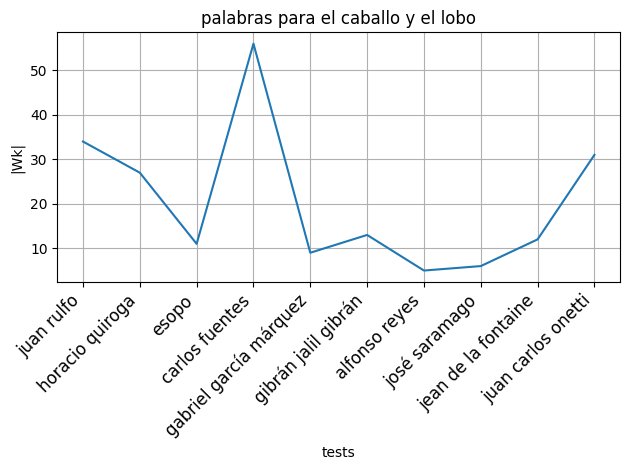

[34, 27, 11, 56, 9, 13, 5, 6, 12, 31]


In [27]:
i = 0
grafica(autores,palabras[i],f'palabras para {tests[i]}','tests','|Wk|')
print(palabras[i])

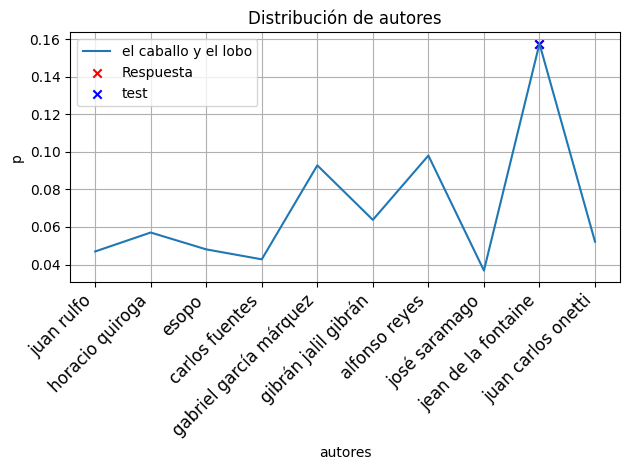

In [35]:
i = 0
titulo = f'Distribución de autores'
y = y_test[i]
label = tests[i]

grafica_a(autores,y,titulo,label,'autores','p', marker_t[i],marker[i])

In [29]:
pr = 0
for i in range(len(marker)):
    if marker_t[i] == marker[i]:
        pr += 1
pr / len(tests)

0.4

#### Propuesta 2

$W^o = \{w^o_1, w^o_2,\dots,w^o_{n_o}\}$, donde $w^o_i$ son las palabras observadas en el test que estan presentes en el corpus del entrenamiento.

**Usando aproximación:**
- $P(A|W^o)$, donde 
    - $\forall w^o_i \in W^o, w^o_i = 1$

In [36]:
tests = ['la melancolía del viajero']
autor = ['jean de la fontaine']
Ns = [100000]
marker_N = []
marker_t_N = []
test_n = 1
autores = list(A.values)
p_test_N = []

for i,test in enumerate(tests):
    p = 0
    va = None
    Wo,dWo = test_vocab(test)
    Q = create_Q(Wo,dWo)
    Wo = tuple(Wo+[T])
    vWo = tuple([1 for k in range(len(Wo))]+['minicuento'])
    for Ni in Ns:
        p_test = []
        for a in autores:
            pa = 0
            for j in range(test_n):
                pa_i = Q.Query(vars=(A,),indep=Wo,vars_values=(a,),indep_values=vWo,aproximation=True,N=Ni,process_n=4)
                print(pa_i)
                pa += pa_i
            p_test.append(pa/test_n)
            
            if pa > p:
                p = pa
                va = a
            
            if a == autor[i]:
                marker_N.append([a,pa])
        marker_t_N.append([va,p])  
        p_test_N.append(p_test)



AttributeError: 'Distrib' object has no attribute 'parents'

In [52]:
i = 0
y = p_test_N[i]
title = "P(A|X^o_1,...,X^o_(n_o))"
label = Ns[i]
marker_t = marker_t_N[i]
marker = marker_N[i]
grafica_a(autores,y,title,label,'autores','P',marker_t,marker     )

IndexError: list index out of range

#### Propuesta 3

Para cada autor:
- $P(A_i,T,W_1,W_2,\dots,W_n) = P(A_i)P(T)\displaystyle \prod_{j=1}^{n} P(W_j|A_i,T)$,
- donde $A_i = \{0,1\}$


In [21]:
autores = set(df_train_T.autor)
tipos = set(df_train_T.tipo)

# Ocurrencias de cada autor y número de ocurrencia de autores
na = Counter(df_train_T.autor)
nA = np.sum(list(na.values()))

# Variables Ai
Ai = {}
for a in autores:
    Ai[a] = mb.Var(a, set([0,1]))

# Variable T 
T = mb.Var('T',tipos)

# Variables Wi
W = {}
for w in nuevo_vocabulario:
    W[w] = mb.Var(w, set([0,1]))

S_Ai = {}

for a in Ai.keys():
    # P(Ai)
    vocab_ai = [w[0] for w in nvocab_a[a]]
    p_ai = na[a] / nA
    tai = {(0,): 1 - p_ai, (1,):p_ai}
    Pai = mb.Distrib(tai, (Ai[a],))
    
    # P(T)
    Pai_T = mb.Distrib(tT_A[(a,)], (T,))
    
    # P(Wj|Ai,T)
    Pai_Wj_AiT = {}
    for w in W:
        tWj_AiT = {}
        for t in T.values:
            tWj_AiT[(1,t)] = {(1,):nw_at[(a,t)][w], (0,):0}
            
            nw_notat = 0
            for not_ai in A.values - set([a]):
                nw_notat += nw_at[(not_ai,t)][w]
            tWj_AiT[(0,t)] = {(1,):nw_notat, (0,):0}
        Laplace_gral(tWj_AiT)
        Pai_Wj_AiT[w] = mb.Distrib(tWj_AiT, (W[w],), (Ai[a],T))

    vars = set([Ai[a],T] + [W[w] for w in W.keys()])
    descomp = tuple([Pai, Pai_T] + [Pai_Wj_AiT[w] for w in W.keys()])
    S_Ai[a] = mb.Specification(vars, descomp)

TypeError: Distrib.__init__() missing 1 required positional argument: 'vars'

In [113]:
def test_vocab(titulo:str) -> tuple:
    dcont = df_test_T.loc[df_test_T['titulo'] == titulo, 'Conteos'].iloc[0]
    wt = []
    for w in dcont:
        wt.append(W[w])
            
    return wt

In [114]:
Q_Ai = {}
for a in S_Ai:
    Q_Ai[a] = mb.Question(S_Ai[a])

In [124]:
tests = ['el caballo y el lobo','el impostor', 'la escopeta','el león y el pastor','la marcha del caracol']
autor = ['jean de la fontaine', 'gibrán jalil gibrán', 'juan carlos onetti','esopo','carlos fuentes']
marker = []
marker_t = []
nvocab_a_w = {}
for a in A.values:
    nvocab_a_w[a] = set([w[0] for w in nvocab_a[a]])
print(nvocab_a_w)
for i,test in enumerate(tests):
    print(f"\nCargando test {i+1}")
    Wo = test_vocab(test)
    
    vocab_t = set()
    for v in Wo:
        vocab_t.add(v.name)
    print(vocab_t)
    
    Wo = tuple(Wo)
    
    vWo = tuple([1 for w in Wo])
    for a in Q_Ai.keys():
        print(f"\t{vocab_t.intersection(nvocab_a_w[a])}")
        Ai = (S_Ai[a].getVar(a),)
        pa = Q_Ai[a].Query(vars=Ai,indep=Wo,vars_values=(1,),indep_values=vWo, aproximation=True,N=25000)
        print(f"\tP({a}) = {pa}")

{'josé saramago': {'agua', 'quedó', 'rana', 'cerdo', 'hacia', 'después', 'muchacha', 'puerta', 'vez', 'sudor', 'bajo', 'ojos', 'muchacho', 'río', 'pasó'}, 'gibrán jalil gibrán': {'años', 'dijo', 'dos', 'sombra', 'hierba', 'hombre', 'príncipe', 'vino', 'día', 'luego', 'poeta', 'obispo', 'respondió', 'vasija', 'poema'}, 'jean de la fontaine': {'casa', 'dijo', 'león', 'cien', 'solo', 'ser', 'debemos', 'fin', 'bien', 'ratoncillo', 'asno', 'amo', 'ayuda', 'amigo', 'perro'}, 'carlos fuentes': {'agua', 'casa', 'filiberto', 'luz', 'chac', 'aquí', 'tan', 'noche', 'mool', 'hoy', 'día', 'vida', 'piedra', 'sólo', 'sótano'}, 'gabriel garcía márquez': {'totó', 'casa', 'años', 'dijo', 'dos', 'luz', 'miércoles', 'fantasma', 'niños', 'padres', 'cuarto', 'papá', 'flotaban', 'bote', 'remos'}, 'esopo': {'zeus', 'pidió', 'viéndose', 'cuervo', 'alas', 'aquella', 'dijo', 'tierra', 'viendo', 'escarabajo', 'águila', 'liebre', 'tan', 'entonces', 'huevos'}, 'juan rulfo': {'siempre', 'tierra', 'urbano', 'dos', 'a